# Softmax regression with $l_1$

In [2]:
!pip install ucimlrepo

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
from scipy.optimize import minimize_scalar
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from ucimlrepo import fetch_ucirepo
from optax.losses import safe_softmax_cross_entropy as cros_entr

# Define softmax function
@jit
def softmax(z):
    exp_z = jnp.exp(z - jnp.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

# Define cross-entropy loss
@jit
def cross_entropy_loss_log(w, X, y):
    predictions = X @ w
    n = len(X)
    log_likelihoods = jax.scipy.special.logsumexp(predictions, axis=1)
    cross_entropy = log_likelihoods - jnp.sum(jnp.multiply(predictions, y), axis=1)
    return (1/n) * jnp.sum(cross_entropy)

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def compute_optimal(X, y, lam):
    n, d = X.shape
    k = y.shape[1]  # Assuming y is one-hot encoded, number of classes

    # Define the variable for weights
    w = cp.Variable((d, k))

    # Construct the objective
    logits = X @ w
    log_likelihoods = cp.log_sum_exp(logits, axis=1)
    cross_entropy_loss = cp.sum(log_likelihoods) - cp.sum(cp.multiply(y, logits))

    # Add l1 regularization
    l1_reg = lam * cp.sum(cp.abs(w))

    # Total loss
    loss = (1/n) * cross_entropy_loss + l1_reg

    # Define the problem
    problem = cp.Problem(cp.Minimize(loss))

    # Solve the problem
    problem.solve()

    # Extract the optimal weights and minimum loss
    w_star = w.value
    f_star = problem.value

    return w_star, f_star

def generate_problem():
    # Fetch dataset from UCI repository
    dataset = fetch_ucirepo(id=697)

    # Extract features and targets
    X = dataset.data.features.values
    y = dataset.data.targets.values.flatten()

    # Create a mapping from unique labels to integers
    unique_labels = np.unique(y)
    num_classes = len(unique_labels)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels to integers using the mapping
    y_integers = jnp.array([label_to_int[label] for label in y])

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_integers, test_size=0.33, random_state=42)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # One-hot encoding using jax
    y_train_one_hot = jax.nn.one_hot(y_train, num_classes)
    y_test_one_hot = jax.nn.one_hot(y_test, num_classes)

    return X_train, y_train_one_hot, X_test, y_test_one_hot

def subgradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: cross_entropy_loss_log(w, X, y)

    iter_start = time.time()
    for i in range(num_iters):
        ### YOUR CODE HERE ###
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times


def proximal_gradient_method(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: cross_entropy_loss_log(w, X, y)

    iter_start = time.time()
    for i in range(num_iters):
        ### YOUR CODE HERE ###
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

# Compute accuracy
def compute_accuracy(w, X, y):
    predictions = softmax(X @ w)
    predicted_classes = jnp.argmax(predictions, axis=1)
    true_classes = jnp.argmax(y, axis=1)
    accuracy = jnp.mean(predicted_classes == true_classes)
    return accuracy

# Compute metrics
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam):
    f = lambda w: cross_entropy_loss_log(w, X_train, y_train) + lam * jnp.sum(jnp.abs(w))
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
        "sparsity": [jnp.mean(jnp.abs(x) < 1e-5) for x in trajectory]
    }
    return metrics

def run_experiments(params):
    lam = params["lam"]
    methods = params["methods"]
    results = {}

    X_train, y_train, X_test, y_test = generate_problem()
    n_features = X_train.shape[1]
    n_classes = len(y_train[0])
    params["n_features"], params["n_classes"] = n_features, n_classes

    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, n_classes))
    x_star, f_star = compute_optimal(X_train, y_train, lam)
    print(f"Optimal accuracy {compute_accuracy(x_star, X_train, y_train)}")

    for method in methods:
        if method["method"] == "Subgrad":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = subgradient_descent(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)
        elif method["method"] == "Proximal":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = proximal_gradient_method(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)

    return results, params

def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    lam = params["lam"]

    plt.suptitle(f"Convex multiclass regression. lam={lam}.")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method + f" sparsity {metrics['sparsity'][-1]:.3f}")
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{lam}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

Optimal accuracy 0.7763157486915588


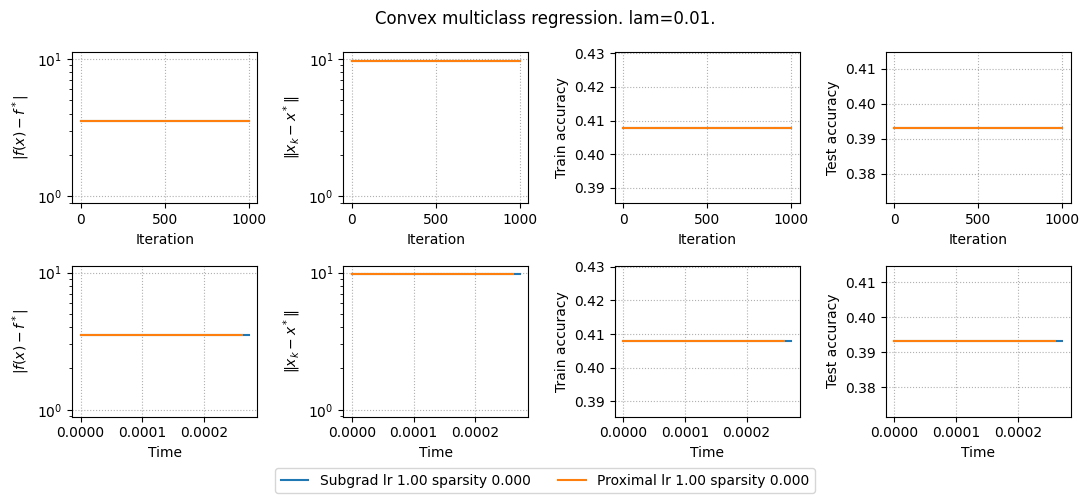

In [4]:
params = {
"lam": 1e-2,
"methods": [
{
"method": "Subgrad",
"learning_rate": 1,
"iterations": 1000,
},
{
"method": "Proximal",
"learning_rate": 1,
"iterations": 1000,
},
]
}
results, params = run_experiments(params)
plot_results(results, params)

In [5]:
def find_max_learning_rate(lamdba, method, tolerance, iterations, st_lr=4, tries=10):
    left = st_lr
    right = 0
    params = {
        "lam": lamdba,
        "methods": [
            {
                "method": method,
                "learning_rate": st_lr,
                "iterations": iterations,
            },
        ]
    }
    lr_history = []
    res_history = dict()
    # do binary search to find the max learning rate
    lr = left
    ans = None
    for i in range(tries):
        lr_history.append(lr)
        params["methods"][0]["learning_rate"] = lr
        results, params = run_experiments(params)
        name, result = next(iter(results.items()))
        res_history[name] = result
        if result["f_gap"][-1] <= tolerance:
            ans = lr
            right = lr
            lr = (left + right) / 2
        else:
            left = lr
            lr = (left + right) / 2

    if ans is None:
        print(f"{method} did not converge to tolerance {tolerance} with lambda {lamdba}")
        return

    name = f"{method} lr {ans:.2f}"
    for k, gap in enumerate(res_history[name]["f_gap"]):
        if gap <= tolerance:
            print(f"{name} converged to f_gap {tolerance} with lambda {lamdba} at iteration {k}")
            break

    params = {
        "lam": lamdba,
        "methods": [
            {
                "method": method,
                "learning_rate": lr,
                "iterations": iterations,
            } for lr in lr_history
        ]
    }
    plot_results(res_history, params)

In [6]:
jax.config.update('jax_platform_name', 'gpu')
find_max_learning_rate(0, "Subgrad", 1e-4, 1000)

Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Subgrad did not converge to tolerance 0.0001 with lambda 0


In [ ]:
find_max_learning_rate(0, "Proximal", 1e-4, 2000)

Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869
Optimal accuracy 0.7817139029502869


[10 points] Solve non-smooth problem and fill the following table. For each value
of provide convergence curves.

In [ ]:
find_max_learning_rate(1e-2, "Subgrad", 1e-1, 1000)
find_max_learning_rate(1e-2, "Subgrad", 1e-2, 1000)
find_max_learning_rate(1e-2, "Subgrad", 1e-3, 1000)
find_max_learning_rate(1e-2, "Subgrad", 1e-4, 1000)
find_max_learning_rate(1e-2, "Subgrad", 1e-5, 1000)
find_max_learning_rate(1e-2, "Proximal", 1e-1, 1000)
find_max_learning_rate(1e-2, "Proximal", 1e-2, 1000)
find_max_learning_rate(1e-2, "Proximal", 1e-3, 1000)
find_max_learning_rate(1e-2, "Proximal", 1e-4, 1000)
find_max_learning_rate(1e-2, "Proximal", 1e-5, 1000)

In [ ]:
find_max_learning_rate(1e-3, "Subgrad", 1e-2, 5000, st_lr=2)
find_max_learning_rate(1e-3, "Proximal", 1e-2, 1000)